In [1]:
# ANNDL Homework 1 - Image Classification
# team: romano_ercolani
# Members: Romanò Francesco | Ercolani Antonio

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/ARTIFICIAL NEURAL NETWORKS AND DEEP LEARNING/CHALLENGE ANNDL/CHALLENGE 1 - Image Classification

/gdrive/MyDrive/ARTIFICIAL NEURAL NETWORKS AND DEEP LEARNING/CHALLENGE ANNDL/CHALLENGE 1 - Image Classification


In [4]:
import os
from PIL import Image
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [5]:
dataset_dir = 'training'

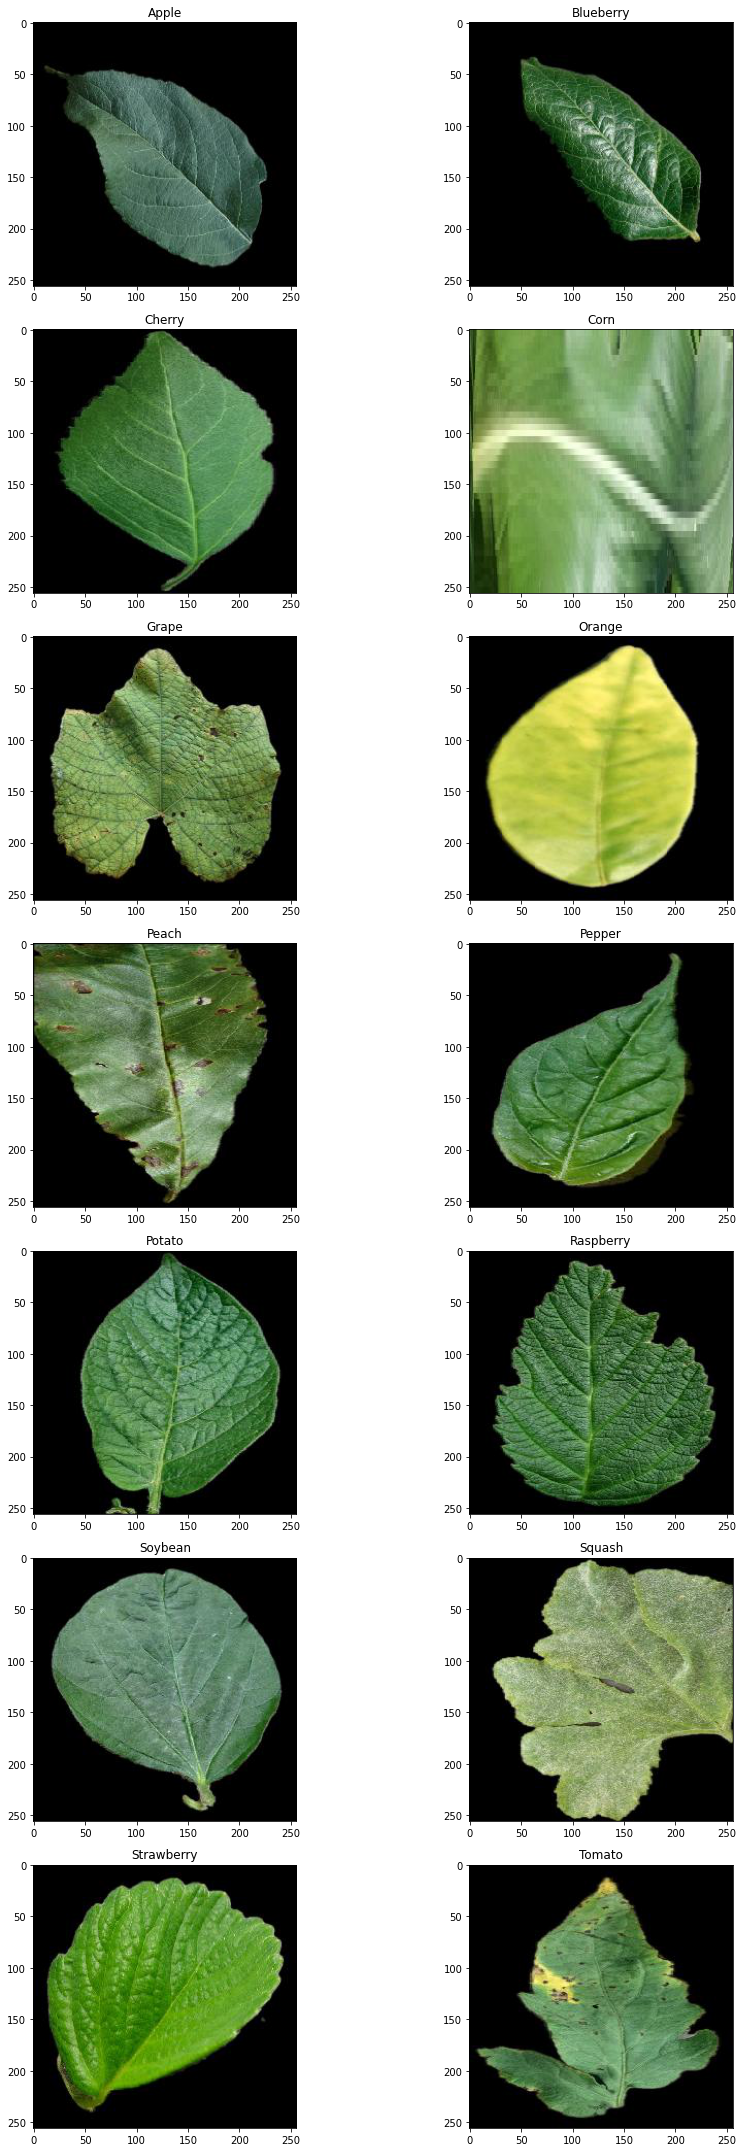

In [ ]:
# Plot example images from dataset
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

num_row = len(labels)//2
num_col = len(labels)//num_row
fig, axes = plt.subplots(num_row, num_col, figsize=(2*num_row,15*num_col))
for i in range(len(labels)):
  if i < len(labels):
    class_imgs = next(os.walk('{}/{}/'.format(dataset_dir, labels[i])))[2]
    class_img = class_imgs[0]
    img = Image.open('{}/{}/{}'.format(dataset_dir, labels[i], class_img))
    ax = axes[i//num_col, i%num_col]
    ax.imshow(np.array(img))
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

In [6]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [7]:
# Exploit ImageDataGenerator to read the data, divided in a folder for each class
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Split data in train/validation 80/20
data_gen = ImageDataGenerator(validation_split=0.2)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=True,
                                               seed=seed,
                                               subset='training')

valid_gen = data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=False,
                                               seed=seed,
                                               subset='validation')

Found 14189 images belonging to 14 classes.
Found 3539 images belonging to 14 classes.


In [8]:
# Check class labels in the data

print("Assigned labels")
print(train_gen.class_indices)
print()
print("Target classes")
print(train_gen.classes)

Assigned labels
{'Apple': 0, 'Blueberry': 1, 'Cherry': 2, 'Corn': 3, 'Grape': 4, 'Orange': 5, 'Peach': 6, 'Pepper': 7, 'Potato': 8, 'Raspberry': 9, 'Soybean': 10, 'Squash': 11, 'Strawberry': 12, 'Tomato': 13}

Target classes
[ 0  0  0 ... 13 13 13]


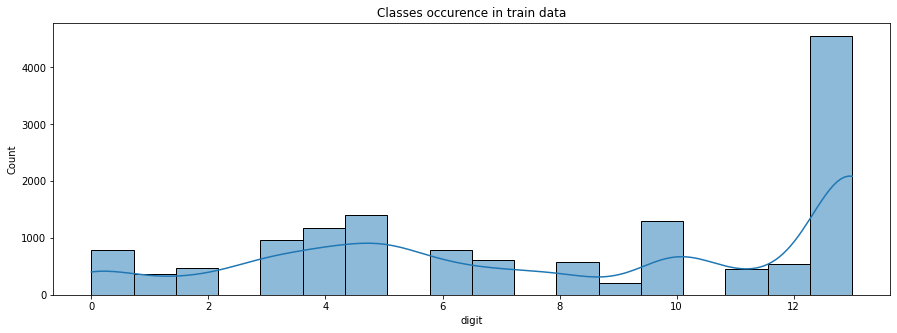

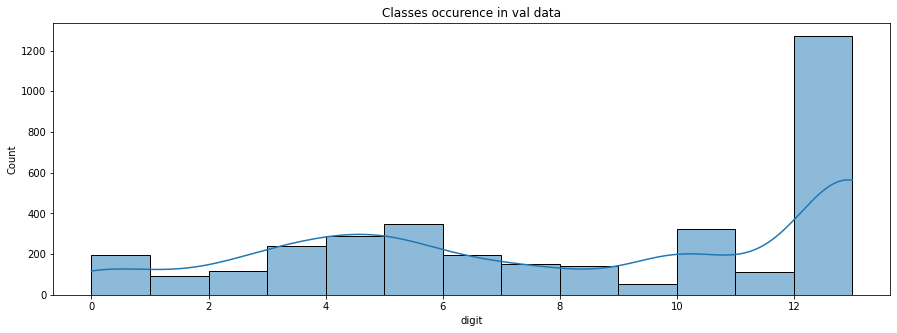

In [9]:
# Data exploration: check class distribution in training and validation data
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(train_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in train data")
plt.show()

plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(valid_gen.classes, columns=['digit']), x='digit', kde=True)
plt.title("Classes occurence in val data")
plt.show()

#Obs: class distribution is more or less preserved in train and val data

In [10]:
# Models metadata
input_shape = (256, 256, 3)
epochs = 200

# Transfer Learning VGG16

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

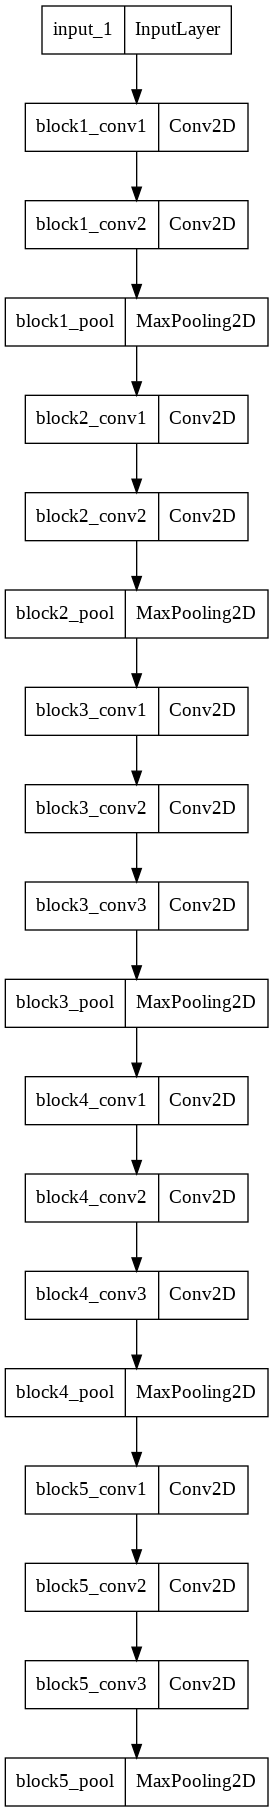

In [11]:
# Model transferred: vgg16
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256, 256, 3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [12]:
# Create the classifier dense top of vgg
supernet.trainable = False

inputs = tfk.Input(shape=(256,256,3))
x = supernet(inputs)
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)

# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 14)                3598      
                                                             

In [13]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('Experiment results')

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp'),
                                                     save_weights_only=False,
                                                     save_best_only=False)
  callbacks.append(ckpt_callback)

  # Early Stopping
  # --------------
  es_callback = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

In [15]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='VGG16_noweightedclass')

# Train model with classes weighted to overcame class imbalance problems
history = tl_model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks
).history

Epoch 1/200
111/111 [==============================] - 2962s 26s/step - loss: 0.7696 - accuracy: 0.8155 - val_loss: 0.2527 - val_accuracy: 0.9214
Epoch 2/200
111/111 [==============================] - 170s 2s/step - loss: 0.1530 - accuracy: 0.9520 - val_loss: 0.1568 - val_accuracy: 0.9506
Epoch 3/200
111/111 [==============================] - 170s 2s/step - loss: 0.1055 - accuracy: 0.9665 - val_loss: 0.1483 - val_accuracy: 0.9573
Epoch 4/200
111/111 [==============================] - 170s 2s/step - loss: 0.0721 - accuracy: 0.9765 - val_loss: 0.1173 - val_accuracy: 0.9630
Epoch 5/200
111/111 [==============================] - 169s 2s/step - loss: 0.0588 - accuracy: 0.9813 - val_loss: 0.1228 - val_accuracy: 0.9599
Epoch 6/200
111/111 [==============================] - 170s 2s/step - loss: 0.0455 - accuracy: 0.9875 - val_loss: 0.1218 - val_accuracy: 0.9565
Epoch 7/200
111/111 [==============================] - 170s 2s/step - loss: 0.0368 - accuracy: 0.9891 - val_loss: 0.0814 - val_accurac

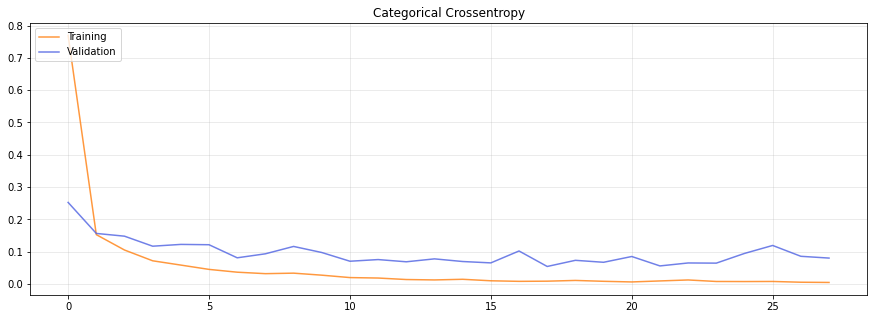

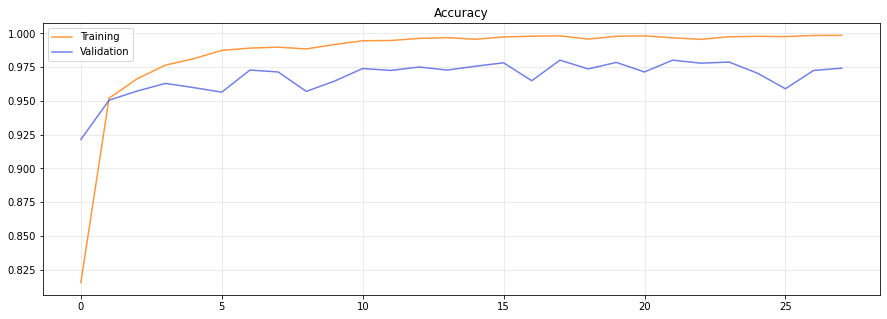

In [16]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [17]:
# this model seems a good starting point :). Let's save it!
tl_model.save("Experiment results/VGG16_noweightedclass")

INFO:tensorflow:Assets written to: Experiment results/VGG16_noweightedclass/assets


THINGS TO CONSIDER: class imbalance (use weights on classes), train/val split, data augmentation, weight decay, learning rate (before used the keras default 0.001